# 3B. PSF modeling and subtraction (with object-oriented modules)

> Authors: *Thomas Bédrine* and *Valentin Christiaens*  
> Suitable for VIP *v1.4.2* onwards and Python *v3.10* onwards  
> Last update: *2024/03/25*

**Table of contents**

* [3.1. Important features needed for the PSF subtraction classes](#3.1.-Important-features-needed-for-the-PSF-subtraction-classes)
    - [3.1.1. General tools for all post-processing classes](#3.1.1.-General-tools-for-all-post-processing-classes)
    - [3.1.2. Loading the ADI data with a Dataset object](#3.1.2.-Loading-the-ADI-data-with-a-Dataset-object)
* [3.2. median-ADI as a first-hand example](#3.2.-median-adi-as-a-first-hand-example)
* [3.3. Pairwise frame difference](#3.3.-Pairwise-frame-difference)
* [3.4. Least-squares approximation (LOCI)](#3.4.-Least-squares-approximation-(LOCI))
* [3.5. Principal Component Analysis (PCA)](#3.5.-Principal-Component-Analysis-(PCA))
    - [3.5.1. Full-frame PCA](#3.5.1.-Full-frame-PCA)
    - [3.5.2. Optimizing the number of PCs for full-frame PCA-ADI](#3.5.2.-Optimizing-the-number-of-PCs-for-full-frame-PCA-ADI)
    - [3.5.3. Full-frame  PCA-ADI with a parallactic angle threshold](#3.5.3.-Full-frame-PCA-ADI-with-a-parallactic-angle-threshold)
    - [3.5.4. PCA for big datacubes](#3.5.4.-PCA-for-big-datacubes)
    - [3.5.5. Annular PCA](#3.5.5.-Annular-PCA)
    - [3.5.6. PCA in a single annulus and PCA grid](#3.5.6.-PCA-in-a-single-annulus-and-PCA-grid)
* [3.6. Non-negative Matrix Factorization (NMF)](#3.6.-Non-negative-Matrix-Factorization-(NMF))
    - [3.6.1. Full-frame NMF](#3.6.1.-Full-frame-NMF)
    - [3.6.2. Annular NMF](#3.6.2.-Annular-NMF)
* [3.7. Local Low-rank plus Sparse plus Gaussian-noise decomposition (LLSG)](#3.7.-Local-Low-rank-plus-Sparse-plus-Gaussian-noise-decomposition-(LLSG))
* [3.8. ANgular Differential OptiMal Exoplanet Detection Algorithm (ANDROMEDA)](#3.8.-ANgular-Differential-OptiMal-Exoplanet-Detection-Algorithm-(ANDROMEDA))
* [3.9. Forward-Model Matched Filter (FMMF)](#3.9.-Forward-Model-Matched-Filter-(FMMF))
* [3.10. All results](#3.10.-All-results)

This tutorial shows:

- how to use the stellar PSF subtraction algorithms already presented in the [3A - PSF Modeling and subtraction](./03A_psfsub.ipynb) tutorial, in an object-oriented approach.
- how to save images obtained through those algorithms and the parameters used to get them.

<div class="alert alert-block alert-info"> 
    <b>Note: </b>
<a class="anchor" id="war1"></a>

This notebook is mostly compatible with Python 3.7 to 3.9 but some parts require Python 3.10. In general, newer versions of Python are always recommended for performance.
</div>

-----------

Let's first import a couple of external packages needed in this tutorial:

In [1]:
%matplotlib inline
%load_ext autoreload
import numpy as np
from hciplot import plot_frames
from matplotlib.pyplot import *
from multiprocessing import cpu_count
from packaging import version
from dataclass_builder import update

We will need version 1.4.2 or above, as well as Python 3.10 or above, to be able to run this tutorial. These requirements are checked in the next cell.

In [2]:
import vip_hci as vip
vvip = vip.__version__
print(f"VIP version: {vvip}")
if version.parse(vvip) < version.parse("1.4.2"):
    msg = "Please upgrade your version of VIP"
    msg+= "It should be 1.4.2 or above to run this notebook."
    raise ValueError(msg)
    
from platform import python_version
vpy = python_version()
print("Python version: ", vpy)
if version.parse(vpy) < version.parse("3.10.0"):
    msg = "To use this notebook, you'll need to upgrade your Python version to 3.10 or above."
    raise ValueError(msg)

VIP version: 1.6.0
Python version:  3.10.13


## 3.1. Important features needed for the PSF subtraction classes

### 3.1.1. General tools for all post-processing classes

First of all, every post-processing class we will see here inherit from the `PostProc` class. However, we shall not instantiate this class because it doesn't implement any algorithm and only serves as a model for every other object. Instead, we will instantiate the inherited classes directly.

The `PostProc` class still does several important tasks :

- identify the attributes that will have to be calculated (typically, the post-processed frames or the signal-to-noise ratio maps);
- calculate the signal-to-noise ratio maps from the post-processed frame;
- set up the needed parameters for each algorithm function.

In order to take full advantage of the object-oriented support, we will also include a container for all the results we get with every object : `PPResult`. This object stores as many sets of parameters and their post-processed frame as we wish, and can also hold the associated signal-to-noise ratio map if we generate one. The purpose of this is to facilitate the analysis of the processed data, and to allow saving them for later use.

Once an instance of `PPResult` is generated, it can be simply passed as a parameter to any object, and will save their results after a use of the `run` or the `make_snrmap`. That same instance can hold results from any algorithm and register the name of the function used, so you can reuse the same object for each of them.

In [3]:
from vip_hci.objects import PPResult

results = PPResult()

<div class="alert alert-block alert-info"> 
    <b>Note: </b>
<a class="anchor" id="war1"></a>

Creating an instance of PPResult (to be later passed as parameter) is optional, if we do not particularly want to store the results, then no instance is required for the use of any post-processing object. It is however quite recommended, as the `PPResult` class offers a built-in function dedicated to frame-plotting (although one can still use the `plot_frames` function of `hciplot`).
</div>

### 3.1.2. Loading the ADI data with a Dataset object

For this tutorial, we will make use of the ADI cube and its associated PSF seen in the first half of this tutorial : [3A - PSF Modeling and subtraction](./03A_psfsub.ipynb). 

More info on this dataset, and on opening and visualizing fits files with VIP in general, is available in Tutorials [1A - Quick start](./01A_quickstart.ipynb) and [1B - Quick start with objects](./01B_quickstart_with_objects.ipynb).

First, we need to load the ADI data as a Dataset object, or open a previously saved Dataset object. More info on how to create a proper Dataset object is available in Tutorial [9 - Using Dataset objects](./09_datasets_as_objects.ipynb).

Let's load the datacube, associated parallactic angles and non-coronagraphic PSF:

In [4]:
from astropy.utils.data import download_file

url_d = "https://github.com/vortex-exoplanet/VIP_extras/raw/master/datasets"
f1 = download_file("{}/naco_betapic_cube_cen.fits".format(url_d), cache=True)
f2 = download_file("{}/naco_betapic_psf.fits".format(url_d), cache=True)
f3 = download_file("{}/naco_betapic_derot_angles.fits".format(url_d), cache=True)

# alternatively, for local files simply provide their full or relative path. E.g.:
#f1 = '../datasets/naco_betapic_cube_cen.fits'
#f2 = '../datasets/naco_betapic_psf.fits'
#f3 = '../datasets/naco_betapic_derot_angles.fits'

In [5]:
from vip_hci.objects import Dataset

betapic = Dataset(cube=f1,
                  psf=f2,
                  angles=f3)

Cube array shape: (61, 101, 101)
Angles array shape: (61,)
PSF array shape: (39, 39)


Let's not forget to normalize the PSF and assign the pixel scale associated with the Dataset.

In [6]:
from vip_hci.config import VLT_NACO

betapic.normalize_psf(size=19)
betapic.px_scale = VLT_NACO["plsc"]


Mean FWHM: 4.801
Flux in 1xFWHM aperture: 1.307
Normalized PSF array shape: (19, 19)
The attribute `psfn` contains the normalized PSF
`fwhm` attribute set to
4.801


We then set the values of `imlib` and `interpolation` to the same values as in tutorial 3A - the default values in VIP, chosen for optimal flux conservation (at the expense of computation speed).

In [7]:
imlib = 'vip-fft'
interpolation=None

Let's visualize the normalized PSF with `hciplot.plot_frames`. Feel free to adapt the `backend` argument throughout the notebook: `'matplotlib'` (default) allows paper-quality figures with annotations which can be saved (default), while `'bokeh'` enables interactive visualization.

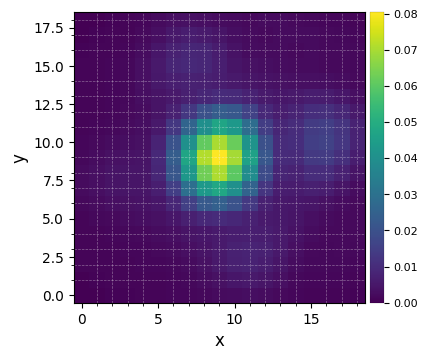

In [8]:
plot_frames(betapic.psfn, grid=True, size_factor=4)

The Dataset object was loaded successfully and matches the results we had so far in 3A. We are now ready to use the PSF subtraction algorithms objects.

## 3.2. median-ADI as a first-hand example

In the 3A section of the tutorial, we saw how every algorithm worked and how to use their associated functions. To avoid as much duplicated explanations as possible, we will focus here on the sole purpose of illustrating the use of objects. We highly recommend to read closely the 3A section for details about all the base algorithm methods seen here.

We will also spend some time presenting as much functionnalities as possible, so later examples can go as quick and easy as possible.

### 3.2.1. Full-frame median-ADI

Let's start with the median substraction algorithm, in full-frame mode.

For the initialization of the median subtraction object, we will make use of a builder. A builder is an object-oriented concept that permits the initialization of an object in several steps. Let's take a look at how it works :

In [9]:
from vip_hci.objects import MedianBuilder

medsub_builder = MedianBuilder(dataset=betapic, mode='fullfr', results=results)
medsub_builder.imlib = imlib
medsub_builder.interpolation = interpolation

medsub_obj = medsub_builder.build()

Here, we fractionned the creation of the object in four separate lines, to show that we can add any parameter at any point, as long as we do it before we actually `build` the object. This is useful if we ever need some parameters that are not defined yet. However, in practice we will most likely have all the parameters we need for the algorithm so we can speed up the process and shorten everything in one line :

In [10]:
medsub_obj = MedianBuilder(dataset=betapic, mode='fullfr', imlib=imlib, interpolation=interpolation,
                           results=results).build()

The object obtained is called a `PPMedianSub`, an object that inherits the `PostProc` class and therefore its built-in functions. All objects that implement an algorithm are named `PP[short_name_for_the_algorithm]`, the exact names can be found in the later parts. But most of the time, we won't be creating a `PPMedianSub` with its own `init` method, but rather with an alternative that we saw above : the `MedianBuilder`. Again, each object gets its own builder, whose name can be found in the imports at the start of the tutorial, or in each of their sections.

Now for the functions that are common to all of those objects, we can check if every parameter is correct in the `medsub_obj` by using the function `print_parameters` :

In [11]:
medsub_obj.print_parameters()

cube : None
angle_list : None
scale_list : None
flux_sc_list : None
fwhm : 4
radius_int : 0
asize : 4
delta_rot : 1
delta_sep : (0.1, 1)
mode : fullfr
nframes : 4
sdi_only : False
imlib : vip-fft
interpolation : None
collapse : median
nproc : 1
full_output : True
verbose : True
dataset : <vip_hci.objects.dataset.Dataset object at 0x106892b00>
results : PPResult(sessions=[])
frame_final : None
signf : None
_algo_name : median_sub
cube_residuals : None
cube_residuals_der : None


There are a lot of parameters here that we didn't give to the builder : those are the default values of the object. It contains both all the variables that need to be passed to the function of the median subtraction algorithm, and the variables we will get as a result of that function. The most important one is `frame_final`, which is the post-processed frame. This attribute is common to every post-processing object and is obtained after a `run` of said object.

Now that the object has been successfully created, we can execute the `run` function. This function can take optional parameters, such as a Dataset - if we did not give one yet, or if we want to change it - or the number of processes dedicated to the execution of algorithm (`nproc`).

In [12]:
medsub_obj.run()

No changes were made to the dataset.
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-06-04 21:59:11
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:16.373005
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


We got several results from this `run`, including our post-processed frame named `frame_final`, or the residuals of the ADI cube (either before or after derotation). The available attributes may change depending on the type of algorithm used, but we will always find `frame_final` as the expected main result. Also, the set of parameters used and the frame obtained had been automatically registered in the `PPResult` object, and may be shown by using the function `show_session_results`. We will take a look at this one after computing the SNR map :

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-06-04 21:59:28
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


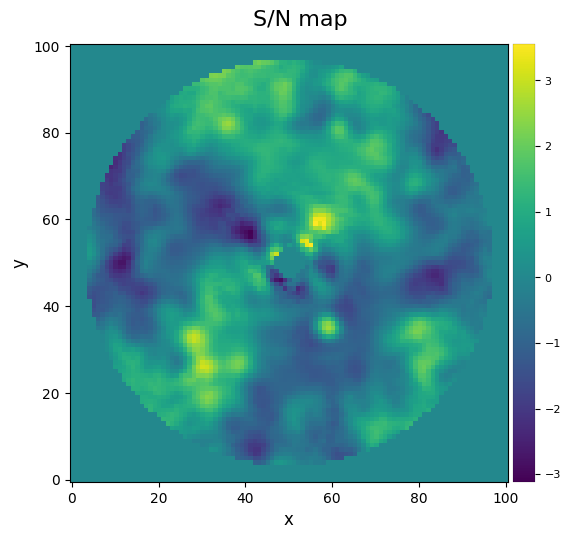

S/N map created using 5 processes
Running time:  0:00:16.439781
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [13]:
medsub_obj.make_snrmap(plot=True)#, backend='bokeh')

Now, the set of parameters, the frame and the map are all three registered in the results. If we use a different set of parameters and launch another `run`, a new entry will be made for that new set and results. 

We can access them with the `show_session_results` and the parameters `session_id` and `label`. The first one is the ID (minus 1) of the data processing session you want to see. By default, it shows the last results you obtained, but you can ask for a specific one. The `label` defines which label you want to put on the frames. It can be a boolean (`True` prints a default label, `False` prints nothing) or a tuple of strings, which will be the label for the corrected frame and the S/N map.

It is also possible to access and print the `frame_final` and the `snr_map` with the usual `plot_frames` function, and it is recommend if you want to create images for scientific paper, as `plot_frames` can take a lot a specific parameters dedicated to customization.

Parameters used for the last session (function used : median_sub) : 
- scale_list : None
- flux_sc_list : None
- fwhm : 4.800919383981533
- radius_int : 0
- asize : 4
- delta_rot : 1
- delta_sep : (0.1, 1)
- mode : fullfr
- nframes : 4
- sdi_only : False
- imlib : vip-fft
- interpolation : None
- collapse : median
- nproc : 1
- full_output : True
- verbose : True


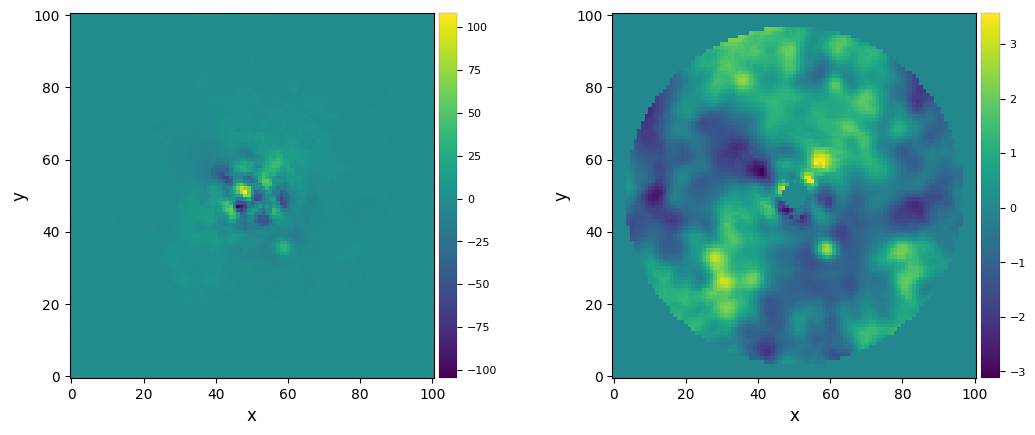

In [14]:
results.show_session_results(label=False)

### 3.2.2. Smart median-ADI

Now let's try another approach of the median subtraction algorithm. In the 3A tutorial, we ran the `median_sub` function another time with different parameters. What we will do here is not much different than that, although we already have an existing `medsub_obj` with valid parameters that can remain unchanged. We will then benefit from the object and execute another `run` while adding new parameters.

We can use the `update` function, which takes the object to update as the first parameter, and a corresponding builder with the wanted parameters as the second one. This will add the desired values to our existing object, and now we are able to `run` immediately with these new parameters :

In [15]:
update(medsub_obj, MedianBuilder(asize=betapic.fwhm, mode='annular', delta_rot=0.5, radius_int=4, nframes=4))
medsub_obj.run()

No changes were made to the dataset.
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-06-04 21:59:46
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 9, FWHM = 4.800919383981533
Processing annuli:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Optimized median psf reference subtracted
Done derotating and combining
Running time:  0:00:16.104677
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Our previously generated `frame_final` has been overwritten by the new run, although it was still registered in `results` in the first entry. We should keep in mind that the object itself only holds one configuration, one frame and one map at a time, but the `PPResult` objects will save each of them :

Parameters used for the session n°1 (function used : median_sub) : 
- scale_list : None
- flux_sc_list : None
- fwhm : 4.800919383981533
- radius_int : 0
- asize : 4
- delta_rot : 1
- delta_sep : (0.1, 1)
- mode : fullfr
- nframes : 4
- sdi_only : False
- imlib : vip-fft
- interpolation : None
- collapse : median
- nproc : 1
- full_output : True
- verbose : True


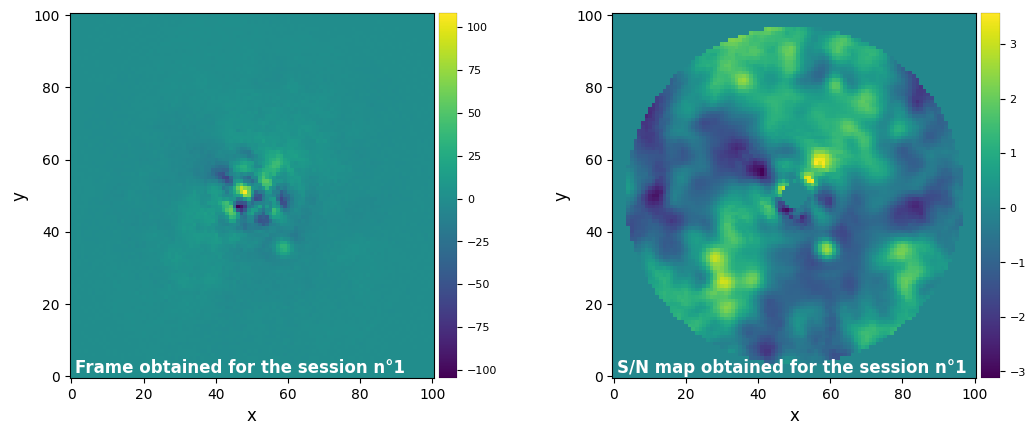

Parameters used for the session n°2 (function used : median_sub) : 
- scale_list : None
- flux_sc_list : None
- fwhm : 4.800919383981533
- radius_int : 4
- asize : 4.800919383981533
- delta_rot : 0.5
- delta_sep : (0.1, 1)
- mode : annular
- nframes : 4
- sdi_only : False
- imlib : vip-fft
- interpolation : None
- collapse : median
- nproc : 1
- full_output : True
- verbose : True


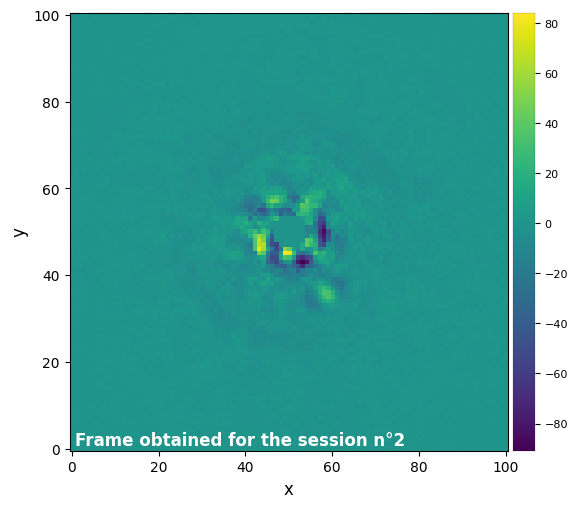

In [16]:
from vip_hci.objects import ALL_SESSIONS

results.show_session_results(session_id=ALL_SESSIONS)

We can include the `snr_map` of the annular version of median subtraction :

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-06-04 22:00:03
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
S/N map created using 5 processes
Running time:  0:00:12.898810
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Parameters used for the session n°1 (function used : median_sub) : 
- scale_list : None
- flux_sc_list : None
- fwhm : 4.800919383981533
- radius_int : 0
- asize : 4
- delta_rot : 1
- delta_sep : (0.1, 1)
- mode : fullfr
- nframes : 4
- sdi_only : False
- imlib : vip-fft
- interpolation : None
- collapse : median
- nproc : 1
- full_output : True
- verbose : True


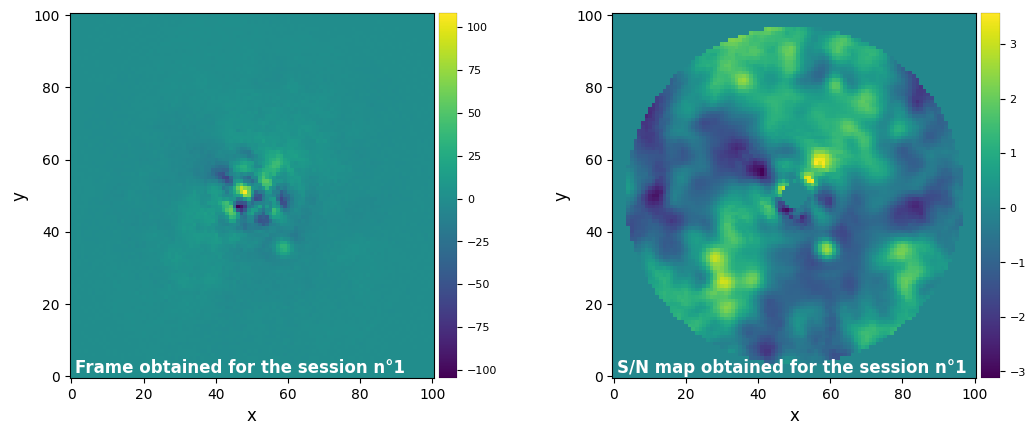

Parameters used for the session n°2 (function used : median_sub) : 
- scale_list : None
- flux_sc_list : None
- fwhm : 4.800919383981533
- radius_int : 4
- asize : 4.800919383981533
- delta_rot : 0.5
- delta_sep : (0.1, 1)
- mode : annular
- nframes : 4
- sdi_only : False
- imlib : vip-fft
- interpolation : None
- collapse : median
- nproc : 1
- full_output : True
- verbose : True


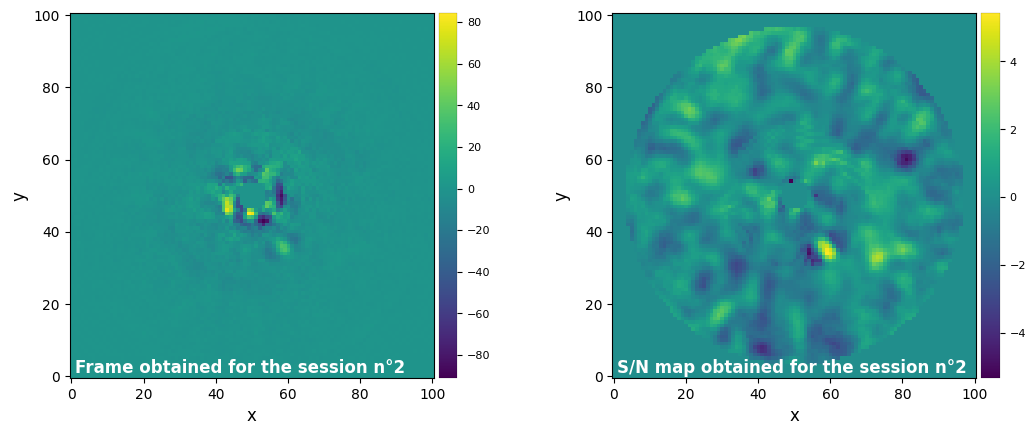

In [17]:
medsub_obj.make_snrmap()
results.show_session_results(session_id=ALL_SESSIONS)

One last tool we may use is the function `get_params_from_results`, which allows us to copy back a previously registered set of parameters into our object. Note that we cannot load a configuration that doesn't match the algorithm we are working with.

In [18]:
medsub_obj.get_params_from_results(session_id=0)

Configuration loaded :
- scale_list : None
- flux_sc_list : None
- fwhm : 4.800919383981533
- radius_int : 0
- asize : 4
- delta_rot : 1
- delta_sep : (0.1, 1)
- mode : fullfr
- nframes : 4
- sdi_only : False
- imlib : vip-fft
- interpolation : None
- collapse : median
- nproc : 1
- full_output : True
- verbose : True


## 3.3. Pairwise frame difference

Let's see the case of the frame differencing algorithm, with its object tools :

In [19]:
from vip_hci.objects import FrameDiffBuilder

frame_diff_obj = FrameDiffBuilder(dataset=betapic, metric='l1', dist_threshold=90, delta_rot=0.5, 
                                  radius_int=4, asize=betapic.fwhm, nproc=None, imlib=imlib, 
                                  interpolation=interpolation, verbose=True, results=results).build()
frame_diff_obj.run()
frame_diff_obj.make_snrmap()

No changes were made to the dataset.
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-06-04 22:00:17
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
9 annuli. Performing pair-wise subtraction:
Ann 1    PA thresh: 21.24    Ann center:   6    N segments: 1 
Ann 2    PA thresh: 12.23    Ann center:  11    N segments: 1 
Ann 3    PA thresh:  8.58    Ann center:  16    N segments: 1 
Ann 4    PA thresh:  6.60    Ann center:  21    N segments: 1 
Ann 5    PA thresh:  5.37    Ann center:  26    N segments: 1 
Ann 6    PA thresh:  4.52    Ann center:  30    N segments: 1 
Ann 7    PA thresh:  3.91    Ann center:  35    N segments: 1 
Ann 8    PA thresh:  3.44    Ann center:  40    N segments: 1 
Ann 9    PA thresh:  3.14    Ann center:  44    N segments: 1 
Done processing annuli
Running time:  0:04:05.211676
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
―――――――――――――――――――――


Let's vizualize the final image with `plot_frames` this time:

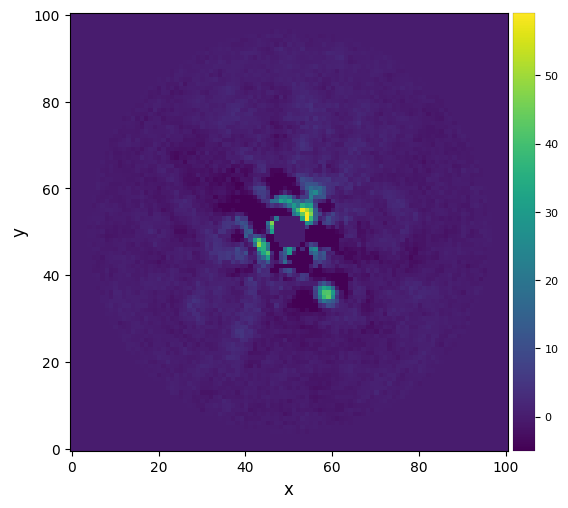

In [20]:
plot_frames(frame_diff_obj.frame_final, vmin=-5)

Although we didn't make use of `results` here, the object still saved the frame and the parameters used here, because the `frame_diff_obj` was given `results` as a parameter. If we want to store the results of each method separately, it is possible to create a separate ``PPResult``-type object for each of them. We can also give no object to save the results, if that isn't necessary. 

A last feature of the `PPResult` that will very likely be useful for us is the ability to save all of those pictures and parameters in a FITS file, specifically as a Multi-Extension FITS. All sessions are saved as separate extensions, saving a frame, its detection frame if any, its parameters and its algorithm inside one extension. This can be done with the function `results_to_fits`, provided a name is given for the file :

In [21]:
results.results_to_fits(filepath='../datasets/example_results_betapic.fits')

FITS file successfully overwritten
Results saved successfully to ../datasets/example_results_betapic.fits !


That same FITS file can be retrieved and converted back to a `PPResult` object, either by using the function `fits_to_results` on an existing object or by specifying the parameter `load_from_path` when creating that object.

In the first case it is possible to only load a specific session by giving an integer for the `session_id` parameter, if none is provided, all sessions will be extracted.

FITS HDU-1 data and header successfully loaded. Data shape: (2, 101, 101)
Parameters used for the session n°1 (function used : median_sub) : 
- scale_list : None
- flux_sc_list : None
- fwhm : 4.800919383981533
- radius_int : 4
- asize : 4.800919383981533
- delta_rot : 0.5
- delta_sep : 0.1
- mode : annular
- nframes : 4
- sdi_only : False
- imlib : vip-fft
- interpolation : None
- collapse : median
- nproc : 1
- full_output : True
- verbose : True


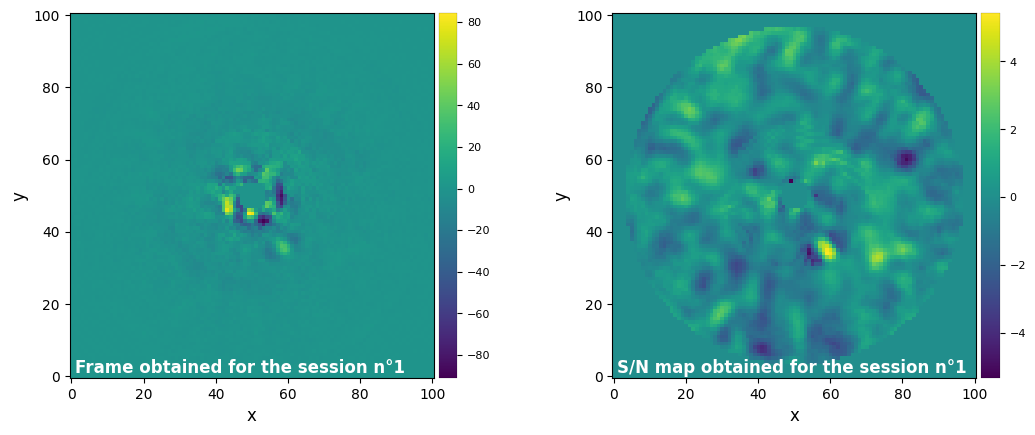

In [22]:
%autoreload 2
results.fits_to_results(filepath='../datasets/example_results_betapic.fits', session_id=1)
results.show_session_results(session_id=ALL_SESSIONS)

FITS HDU-0 data and header successfully loaded. Data shape: (2, 101, 101)
FITS HDU-1 data and header successfully loaded. Data shape: (2, 101, 101)
FITS HDU-2 data and header successfully loaded. Data shape: (2, 101, 101)
All 3 FITS HDU data and headers successfully loaded.
Parameters used for the session n°1 (function used : median_sub) : 
- scale_list : None
- flux_sc_list : None
- fwhm : 4.800919383981533
- radius_int : 0
- asize : 4
- delta_rot : 1
- delta_sep : 0.1
- mode : fullfr
- nframes : 4
- sdi_only : False
- imlib : vip-fft
- interpolation : None
- collapse : median
- nproc : 1
- full_output : True
- verbose : True


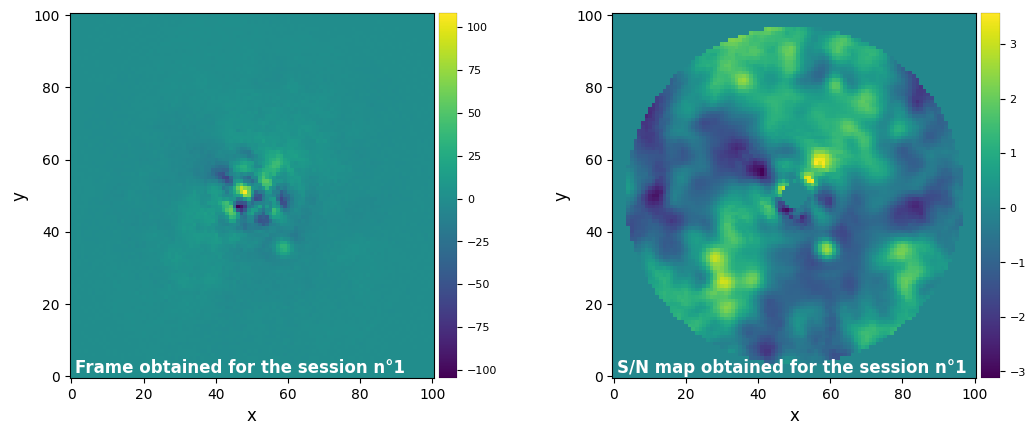

Parameters used for the session n°2 (function used : median_sub) : 
- scale_list : None
- flux_sc_list : None
- fwhm : 4.800919383981533
- radius_int : 4
- asize : 4.800919383981533
- delta_rot : 0.5
- delta_sep : 0.1
- mode : annular
- nframes : 4
- sdi_only : False
- imlib : vip-fft
- interpolation : None
- collapse : median
- nproc : 1
- full_output : True
- verbose : True


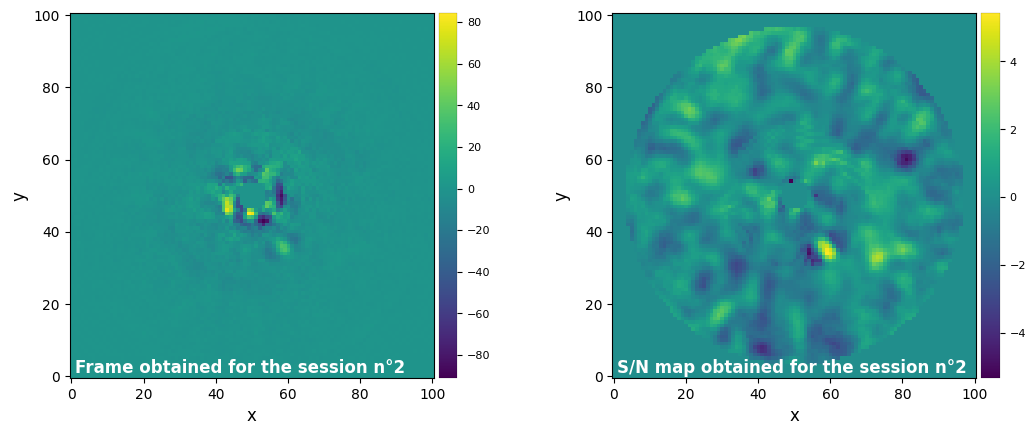

Parameters used for the session n°3 (function used : frame_diff) : 
- fwhm : 4.800919383981533
- metric : l1
- dist_threshold : 90
- n_similar : None
- delta_rot : 0.5
- radius_int : 4
- asize : 4.800919383981533
- ncomp : None
- imlib : vip-fft
- interpolation : None
- collapse : median
- nproc : 1
- verbose : True
- debug : False
- full_output : True


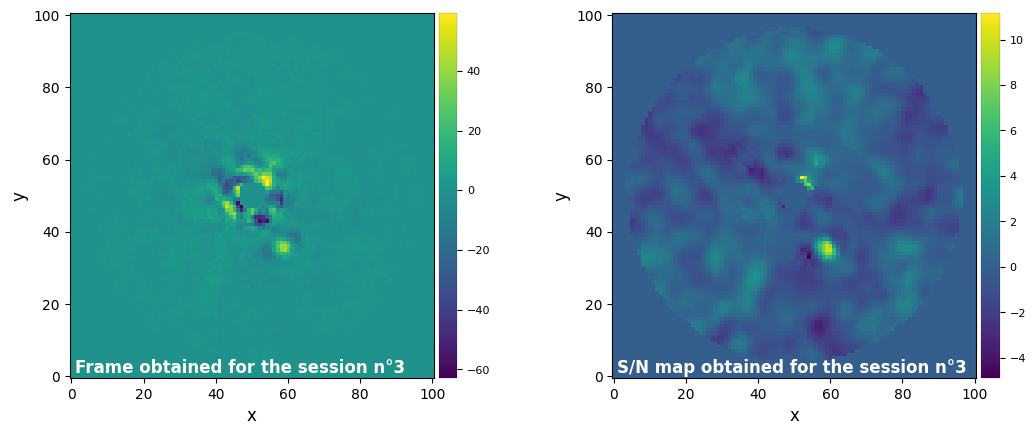

In [23]:
results = PPResult(load_from_path='../datasets/example_results_betapic.fits')
results.show_session_results(session_id=ALL_SESSIONS)

## 3.4. Least-squares approximation (LOCI)

Now, another example with LOCI :

In [24]:
from vip_hci.objects import LOCIBuilder

loci_obj = LOCIBuilder(dataset=betapic, asize=betapic.fwhm, n_segments='auto', nproc=None, 
                       metric='correlation', dist_threshold=90, delta_rot=0.1, optim_scale_fact=2,
                       solver='lstsq', tol=0.01, imlib=imlib, interpolation=interpolation, results= results).build()
loci_obj.run()

No changes were made to the dataset.
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-06-04 22:04:45
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Building 10 annuli:
Ann 1    PA thresh: 11.42    Ann center:   2    N segments: 2 
Ann 2    PA thresh:  3.82    Ann center:   7    N segments: 3 
Ann 3    PA thresh:  2.29    Ann center:  12    N segments: 5 
Ann 4    PA thresh:  1.64    Ann center:  17    N segments: 7 
Ann 5    PA thresh:  1.27    Ann center:  22    N segments: 9 
Ann 6    PA thresh:  1.04    Ann center:  26    N segments: 11 
Ann 7    PA thresh:  0.88    Ann center:  31    N segments: 12 
Ann 8    PA thresh:  0.76    Ann center:  36    N segments: 14 
Ann 9    PA thresh:  0.67    Ann center:  41    N segments: 16 
Ann 10    PA thresh:  0.62    Ann center:  45    N segments: 18 
Patch-wise least-square combination and subtraction: with 5 processes
Done processing annuli
Running time:  0:


Let's vizualize the final image:

Parameters used for the last session (function used : xloci) : 
- scale_list : None
- fwhm : 4.800919383981533
- metric : correlation
- dist_threshold : 90
- delta_rot : 0.1
- delta_sep : (0.1, 1)
- radius_int : 0
- asize : 4.800919383981533
- n_segments : auto
- nproc : None
- solver : lstsq
- tol : 0.01
- optim_scale_fact : 2
- adimsdi : skipadi
- imlib : vip-fft
- interpolation : None
- collapse : median
- verbose : True
- full_output : True


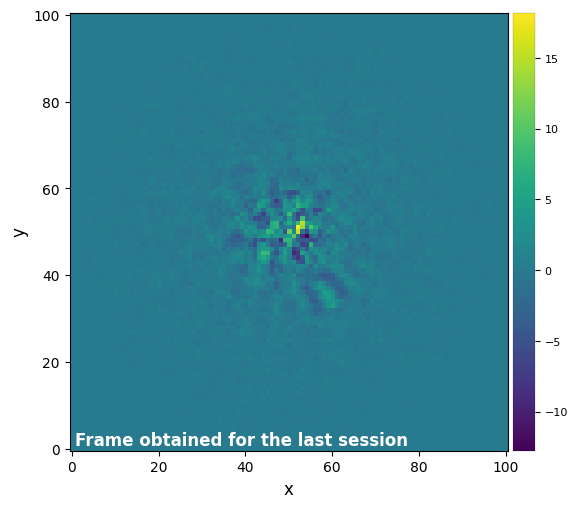

In [25]:
results.show_session_results()

## 3.5. Principal Component Analysis (PCA)

The PCA case is a bit different. As it is one of the most common ways of modeling and subtracting the stellar PSF, VIP offers several flavours of PCA, for various usages, and thus the `PPPCA` object has a lot more to offer than the previous examples we saw.

### 3.5.1. Full-frame PCA

As always, we will be following the same steps as the [3A tutorial PCA part](./03A_psfsub.ipynb#3.5.-Principal-Component-Analysis-(PCA)). The first thing we will try here is to do a simple execution of PCA in full-frame mode, with 5 principal components :

In [26]:
from vip_hci.objects import PCABuilder
ncomp = 5
pca_obj = PCABuilder(dataset=betapic, ncomp=ncomp, mask_center_px=None, imlib=imlib, interpolation=interpolation,
                     svd_mode='lapack', results=results).build()
pca_obj.run()
pca_obj.make_snrmap()

No changes were made to the dataset.
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-06-04 22:23:51
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 3.333 GB
Done vectorizing the frames. Matrix shape: (61, 10201)
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:12.215456
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done de-rotating and combining
Running time:  0:00:29.926599
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
These attributes were just calculated:
	frame_final
	cube_reconstructed
	cube_residuals
	cube_residuals_der
	pcs
	cube_residuals_per_channel
	cube_residuals_per_channel_der
	cube_residuals_resc
	final_residuals_cube
	medians
	dataframe
	opt_number_pc
The following attributes can be calculated now:
	detection_map	with .make_snrmap()
――――――――――――――――――――

We are going to introduce a new tool of the `PostProc` line here, and to do that, we will need the position of a possible companion. Let's show the frame obtained with the first run of PCA :

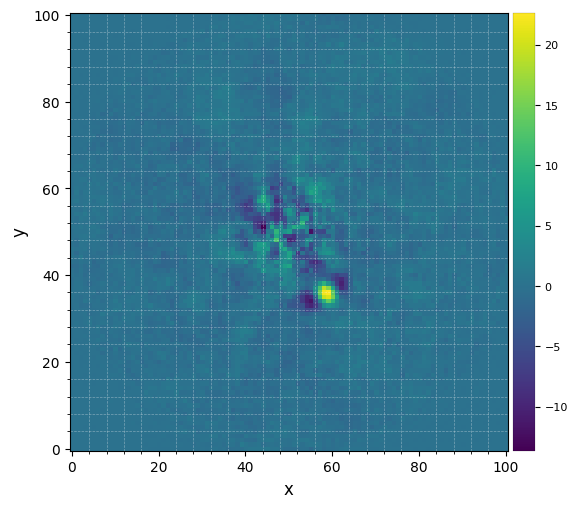

In [27]:
plot_frames(pca_obj.frame_final, grid=True)

Using this frame, we can identify a candidate companion which is the bright point surrounded by negative lobes. Its coordinates in the frame are the following : 

In [28]:
xy_b = (58.5, 35.5)

Now with this point and the previously obtained frame, we are able to compute the significance of that candidate, by using the built-in function `compute_significance`. This function needs at least the coordinates of the candidate and a corrected frame. If no detection map was generated through `make_snrmap`, it will be created inside `compute_significance`.

In [29]:
pca_obj.compute_significance(source_xy=xy_b)

At a separation of 16.8 px (3.5 FWHM), S/N = 7.7 corresponds to a 5.2-sigma detection in terms of Gaussian false alarm probability.
5.2 sigma detection


### 3.5.2. Optimizing the number of PCs for full-frame PCA-ADI

As mentionned in the 3A tutorial, the PCA method shows far better results than a method like median subtraction, and can give even better results with proper settings. For example, it is possible to find the optimal number of principal components for our dataset. This was done by giving to the `pca` function a range of PCs to test and identify the one that the highest S/N ratio for a specific point.

One can provide a list of different `ncomp` values to be tested to get an idea of what's present in the data:

In [30]:
ncomp_list = [2, 5, 10, 20, 40]
update(pca_obj, PCABuilder(ncomp=ncomp_list))
pca_obj.run()

No changes were made to the dataset.
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-06-04 22:24:41
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 3.070 GB
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:10.694836
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Computed residual frames for PCs interval: [2, 5, 10, 20, 40]
Number of steps 5
Running time:  0:01:45.223450
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
These attributes were just calculated:
	frame_final
	cube_reconstructed
	cube_residuals
	cube_residuals_der
	pcs
	cube_residuals_per_channel
	cube_residuals_per_channel_der
	cube_residuals_resc
	final_residuals_cube
	medians
	dataframe
	opt_number_pc


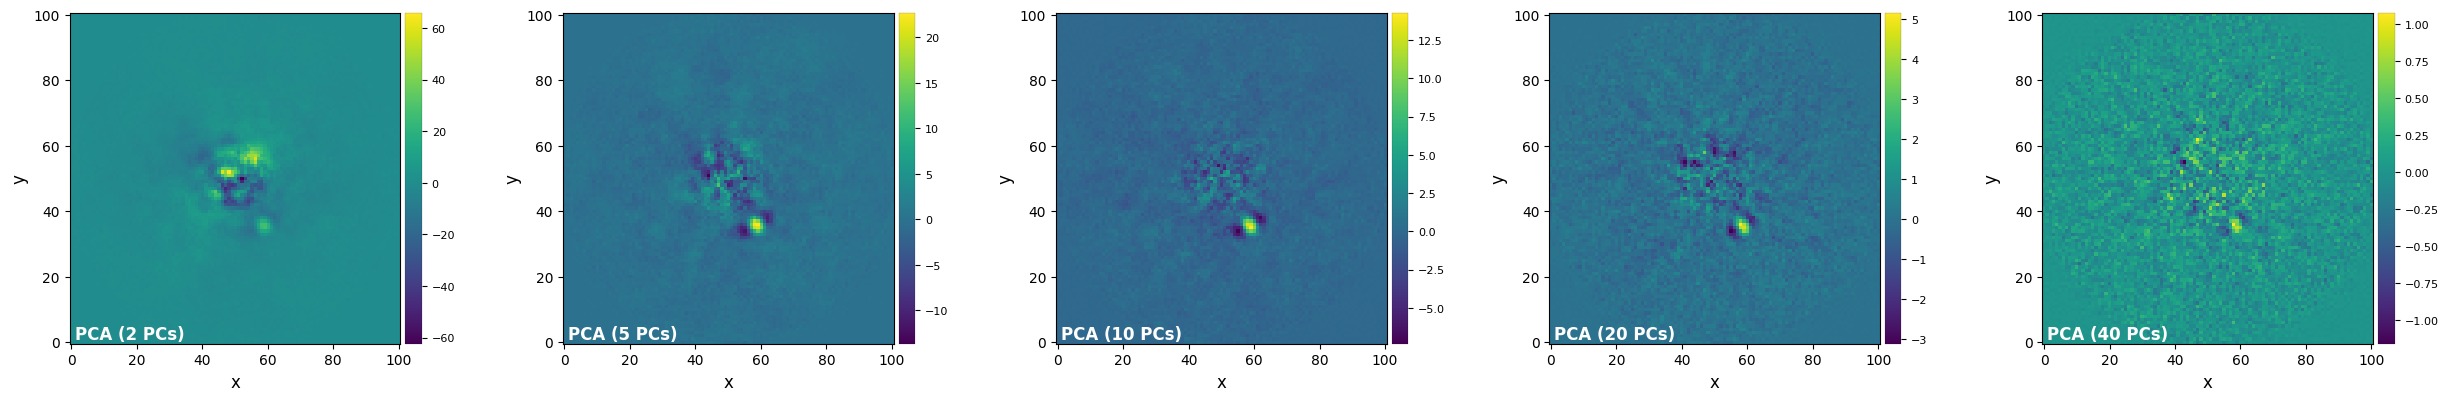

In [31]:
labels = tuple(['PCA ({} PCs)'.format(ncomp_list[i]) for i in range(len(ncomp_list))])
plot_frames(pca_obj.frames_final, label=labels)

Since we have 61 frames in our cube, we can also take the full range from 1 to 61 principal components, going by a step of 2, and find the optimal number of principal components that maximize the S/N measured at position `xy_b`:

No changes were made to the dataset.
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-06-04 22:26:30
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 3.052 GB
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:10.624137
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Number of steps 31
Optimal number of PCs = 13, for S/N=9.093
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Coords of chosen px (X,Y) = 58.5, 35.5
Flux in a centered 1xFWHM circular aperture = 117.483
Central pixel S/N = 11.308
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Inside a centered 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 9.093
Max S/N (shifting the aperture center) = 12.204
stddev S/N (shifting the aperture center) = 1.975

These attributes 

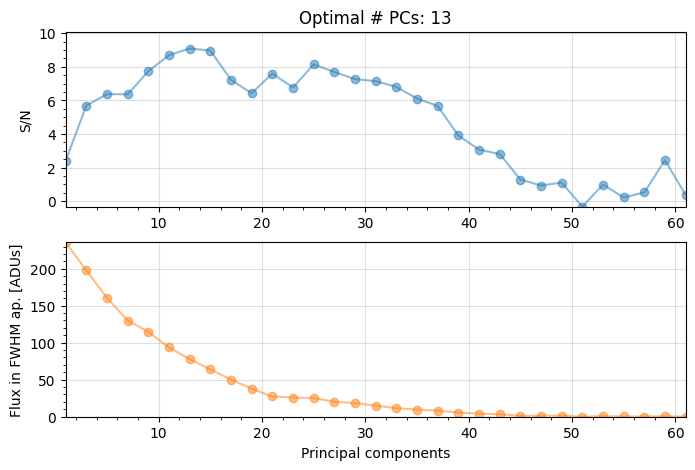

In [32]:
update(pca_obj, PCABuilder(source_xy=xy_b, ncomp=(1, 61, 2)))
pca_obj.run()

We have now found that the optimal number of principal components is 13. The following enables to access this info, together with the associated post-processed frame:

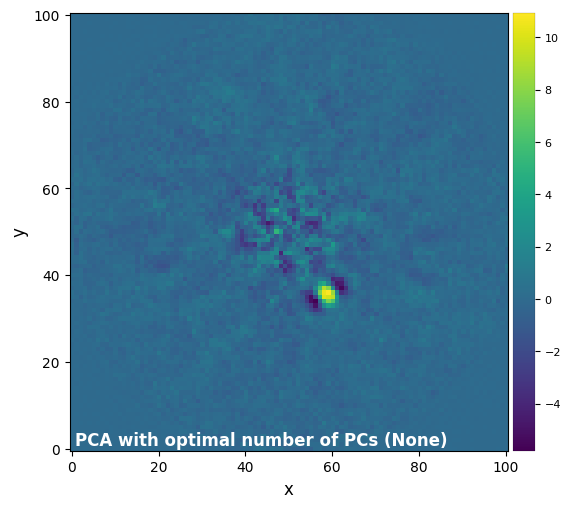

In [33]:
pca_13 = pca_obj.frame_final
opt_npc = pca_obj.opt_number_pc
plot_frames(pca_13, label='PCA with optimal number of PCs ({})'.format(opt_npc))

<div class="alert alert-block alert-info"> 
    <b>Note: </b>
<a class="anchor" id="war1"></a>

At any time you can fetch earlier frames calculated in the session, and compare them with any other frame calculated in the session. For example, the cell below compares the images obtained with 5 PCs (first test) together with the latest run where we inferred the optimal number of PCs.
</div>

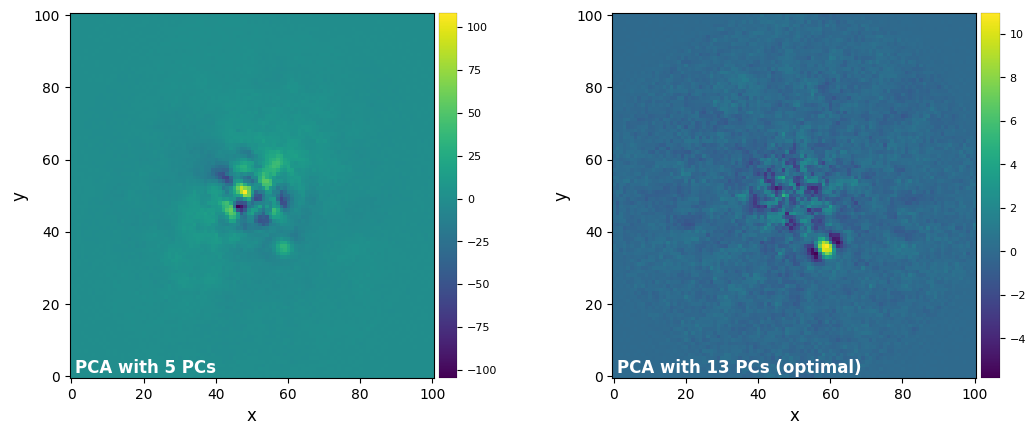

In [34]:
pca_5, pca_13 = [results.sessions[i].frame for i in [0,-1]] # to fetch the first and last runs, respectively
plot_frames((pca_5,pca_13), label=('PCA with 5 PCs','PCA with 13 PCs (optimal)'))

As for the [3A Tutorial](./03A_psfsub.ipynb#3.5.2.-Optimizing-the-number-of-PCs-for-full-frame-PCA-ADI), we can compare the upgrade in quality with 13 principal components by taking another look at the significance :

In [35]:
pca_obj.compute_significance(source_xy=xy_b)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-06-05 01:08:33
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
S/N map created using 5 processes
Running time:  0:15:58.650718
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
At a separation of 16.8 px (3.5 FWHM), S/N = 11.3 corresponds to a 6.3-sigma detection in terms of Gaussian false alarm probability.
6.3 sigma detection


### 3.5.3. Full-frame PCA-ADI with a parallactic angle threshold

We can partially avoid the companion self-subtraction with full-frame PCA by applying a PA threshold for a given distance from the center. This is more efficient if a lot of rotation is present in the data. As seen in 3A, this dataset is well suited for this option, which allows us to try another set of parameters and should reduce the self-subtraction.

In [36]:
update(pca_obj, PCABuilder(ncomp=29, delta_rot=1))
pca_obj.run()

No changes were made to the dataset.
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-06-05 01:24:32
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 4.400 GB
Size LIB: min=29.0 / 1st QU=33.0 / med=38.0 / 3rd QU=43.0 / max=51.0
Done de-rotating and combining
Running time:  6:06:07.001720
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
These attributes were just calculated:
	frame_final
	cube_reconstructed
	cube_residuals
	cube_residuals_der
	pcs
	cube_residuals_per_channel
	cube_residuals_per_channel_der
	cube_residuals_resc
	final_residuals_cube
	medians
	dataframe
	opt_number_pc


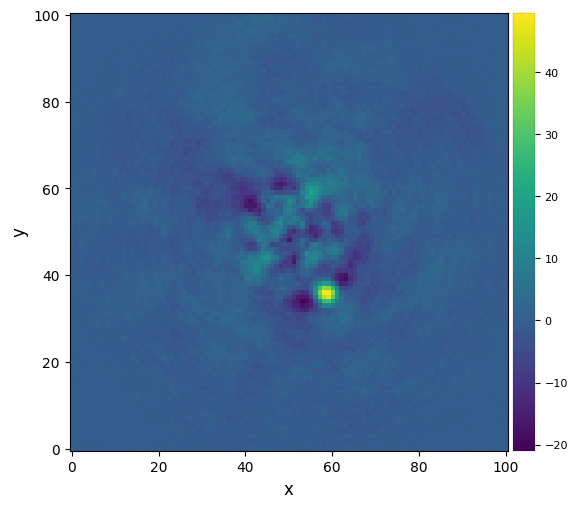

In [37]:
plot_frames(pca_obj.frame_final)

### 3.5.4. PCA for big datacubes

As discussed in 3A, PCA can require a lot of resources, especially on very large datacubes. The option to decompose the cube in batches is still available :

No changes were made to the dataset.
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-06-05 07:30:40
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 3.238 GB
Cube size = 0.002 GB (61 frames)
Batch size = 31 frames (0.001 GB)

Batch 1/2	shape: (31, 101, 101)	size: 1.3 MB
Batch 2/2	shape: (30, 101, 101)	size: 1.2 MB
Running time:  0:00:26.642213
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Reconstructing and obtaining residuals
Running time:  0:00:46.163733
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
These attributes were just calculated:
	frame_final
	cube_reconstructed
	cube_residuals
	cube_residuals_der
	pcs
	cube_residuals_per_channel
	cube_residuals_per_channel_der
	cube_residuals_resc
	final_residuals_cube
	medians
	dataframe
	opt_number_pc
Parameters used for the last

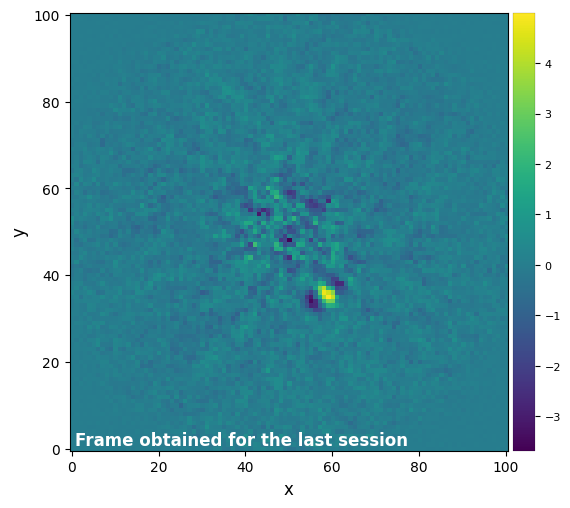

In [38]:
update(pca_obj, PCABuilder(ncomp=19, batch=31, source_xy=None))
pca_obj.run()
results.show_session_results()

### 3.5.5. Annular PCA

PCA can also be performed on concentric annuli, and including a parallactic angle threshold when building the PCA library associated to each image. This is the same idea used before in full-frame when the position of a source of interest was defined except that the PA threshold here will be adjusted depending on the radial distance of each annulus from the star. PCA can be computed in full annuli or in separate annular segments (``n_segments``). The computational cost increases accordingly.

The PPPCA object can be used in four different modes, and until now we only made use of the default 'classic' `runmode`. This time, with the right parameters, we can try the 'annular' `runmode` instead. This is configured through the `run` function only.

Let's update the `pca_obj` with 3 segments per annulus, 6 principal components, a 0.2 FWHM rotation threshold, and multi-processing mode:

In [39]:
update(pca_obj, PCABuilder(ncomp=6, asize=betapic.fwhm, delta_rot=0.2, nproc=None, n_segments=3))
pca_obj.run(runmode='annular')
pca_obj.make_snrmap()

No changes were made to the dataset.
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-06-05 07:31:26
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 10, FWHM = 4.801
PCA per annulus (or annular sectors):
Ann 1    PA thresh: 22.62    Ann center:   2    N segments: 3 
Done PCA with lapack for current annulus
Running time:  0:00:00.110582
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh:  7.63    Ann center:   7    N segments: 3 
Done PCA with lapack for current annulus
Running time:  0:02:36.808967
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 3    PA thresh:  4.58    Ann center:  12    N segments: 3 
Done PCA with lapack for current annulus
Running time:  0:06:35.486401
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 4    PA thresh:  3.27    Ann center:  17    N segme

The parameter `ncomp` can be set to *auto* for letting the algorithm define automatically the number of PCs for each annular patch (instead of fixing it for all of them). The optimal value is found when the standard deviation of the residuals after the subtraction of the PCA approximation drops below a given (absolute) tolerance `tol` while progressively increasing the number of principal components.

In [40]:
update(pca_obj, PCABuilder(ncomp='auto', tol=0.1))
pca_obj.run(runmode='annular')
pca_obj.make_snrmap()

No changes were made to the dataset.
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-06-05 10:47:48
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 10, FWHM = 4.801
PCA per annulus (or annular sectors):
Ann 1    PA thresh: 22.62    Ann center:   2    N segments: 3 
Done PCA with lapack for current annulus
Running time:  0:00:00.137616
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh:  7.63    Ann center:   7    N segments: 3 
Done PCA with lapack for current annulus
Running time:  0:01:56.436800
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 3    PA thresh:  4.58    Ann center:  12    N segments: 3 
Done PCA with lapack for current annulus
Running time:  0:04:20.674496
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 4    PA thresh:  3.27    Ann center:  17    N segme

KeyboardInterrupt: 

<div class="alert alert-block alert-info"> 
    <b>Note: </b>
<a class="anchor" id="war1"></a>

Setting `ncomp='auto'` as above is different to finding the optimal $n_{\rm pc}$ that maximizes the S/N ratio of a given companion (as the former does not require any companion). The latter is activated instead either: 

- by setting a list/tuple for `ncomp` and providing `source_xy` coordinates for the companion in the `pca` (not `pca_annular`) function ([Sec. 3.5.2](#3.5.2.-Optimizing-the-number-of-PCs-for-full-frame-PCA-ADI));
- by using the `pca_grid` function ([Sec. 3.5.6](#3.5.6.-PCA-in-a-single-annulus-and-PCA-grid)).
</div>

Now let's compare both images:

In [ ]:
pca_an6, pca_auto = [results.sessions[i].frame for i in [-2,-1]]
plot_frames((pca_an6, pca_auto), dpi=100, vmin=-5, colorbar=True)

As for the `pca` function, `pca_annular` can accept either a list of npc values or a tuple of 3 values for `ncomp` which will make it explore a range of different npcs at once. The advantage of using this feature is that the principal components are only computed once - compared to a manual loop over the function which will make it compute again all principal components.

In [ ]:
update(pca_obj, PCABuilder(fwhm=betapic.fwhm, ncomp=[1,5,10,20], 
                           asize=20.))
pca_obj.run(runmode='annular')
plot_frames(pca_obj.frames_final)

<div class="alert alert-block alert-info"> 
    <b>Note: </b>
<a class="anchor" id="war1"></a>

It is important to ensure what parameters need to be updated. On objects that have multiple modes - such as PPPCA - there are a lot of parameters that can show up and affect the run of the functions. It is recommended to use the function `print_parameters` seen in [Sec. 3.2](#3.2.-median-adi-as-a-first-hand-example), to show what are the current parameters.
</div>

### 3.5.6. PCA in a single annulus and PCA grid

Once a companion candidate has been identified, the fastest way to recover (and hence characterize) it is to apply PCA on a single annulus encompassing the companion candidate, and finding the optimal number of principal components. This leads us to the third `runmode` of PPPCA, "annulus". The method of updating remains unchanged.

In [ ]:
from vip_hci.var import frame_center
%autoreload 2
ncomp_test = 5
cy, cx = frame_center(betapic.cube)
rad = np.sqrt((cy-xy_b[1])**2+(cx-xy_b[0])**2)
update(pca_obj, PCABuilder(ncomp=ncomp_test, annulus_width=3*betapic.fwhm, r_guess=rad))
pca_obj.run(runmode='annulus')

In [ ]:
plot_frames(pca_obj.frame_final, label='PCA annulus (npc={:.0f})'.format(ncomp_test),
            dpi=100, vmin=-5, colorbar=True)

Let's now use `pca_grid` to search for the optimal $n_{\rm pc}$ that maximizes the S/N ratio of a given point source. This is the fourth and last `runmode` of PPPCA, 'grid'. As explained in 3A, the grid mode is suited for `pca`, `pca_annular` or `pca_annulus`, let's take a look at how it translates with PPPCA :

In [ ]:
%autoreload 2
# full frame
update(pca_obj, PCABuilder(range_pcs=(1,31,1), source_xy=xy_b, mode='fullfr', plot=True))
pca_obj.run(runmode='grid')
frame_ff = pca_obj.frame_final
opt_ff = pca_obj.opt_number_pc

# single annulus with no PA threshold
update(pca_obj, PCABuilder(mode='annular', annulus_width=3*betapic.fwhm))
pca_obj.run(runmode='grid')
frame_ann = pca_obj.frame_final
opt_ann = pca_obj.opt_number_pc

For full-frame PCA the optimal npc is found to be 13 (as already seen in [Sec. 3.5.2](#3.5.2.-Optimizing-the-number-of-PCs-for-full-frame-PCA-ADI)).

For PCA on a single annulus, the optimal npc is found to be 7, hence lower.

Let's plot the final images below. Note that since we ran `pca_grid` with the `full_output=True` option, both final images and optimal number of pcs are returned (among other outputs).

In [ ]:
plot_frames((frame_ff, frame_ann), label=('PCA-opt full-frame (npc={:.0f})'.format(opt_ff), 
                                          'PCA-opt annulus (npc={:.0f})'.format(opt_ann)),
            dpi=100, vmin=-5, colorbar=True)

## 3.6. Non-negative Matrix Factorization (NMF)

A PSF reference can be modelled using a low-rank approximation different than PCA (which relies on singular value decomposition). Non-negative matrix factorization can be used instead ([Gomez Gonzalez et al. 2017](https://ui.adsabs.harvard.edu/abs/2017AJ....154....7G/abstract); [Ren et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...852..104R/abstract)). Instead of $M = U\Sigma V$ (SVD), non-negative matrix factorization can be written as $M = \mathcal{W} \mathcal{H}$, where both matrices are non-negative, and the columns of $\mathcal{H}$ are the non-zero components onto which the images are projected (note that the residuals after model subtraction can be negative though).

The two matrices are typically found iteratively. Currently, the default method in VIP is based on the `scikit-learn` implementation of NMF, which uses the principal components obtained by SVD as first guess of the iterative process. Therefore, the results can look fairly similar to PCA, in particular if the PCs are mostly non-negative.

Two approaches are available : `nmf` and `nmf_annular`, which combine into one object `PPNMF`. Let's take a look at the full-frame runmode.

### 3.6.1. Full-frame NMF

Full-frame NMF is the default for `PPNMF` and takes similar arguments as for PCA.

In [ ]:
from vip_hci.objects import NMFBuilder
nmf_obj = NMFBuilder(dataset=betapic, ncomp=14, max_iter=10000, init_svd='nndsvdar', mask_center_px=None, imlib=imlib, 
             interpolation=interpolation, results=results).build()
nmf_obj.run()
nmf_obj.make_snrmap()
results.show_session_results()

### 3.6.2. Annular NMF

To use the annular version of NMF, one should update parameters of the builer, and use the runmode 'annular'.

In [ ]:
update(nmf_obj, NMFBuilder(ncomp=9, radius_int=0, nproc=None, asize=betapic.fwhm))
nmf_obj.run(runmode="annular")
nmf_obj.make_snrmap()
results.show_session_results()

## 3.7. Local Low-rank plus Sparse plus Gaussian-noise decomposition (LLSG)

Local Low-rank plus Sparse plus Gaussian-noise decomposition (LLSG; [Gomez Gonzalez et al. 2016](https://ui.adsabs.harvard.edu/abs/2016A%26A...589A..54G/abstract)) proposes a three terms decomposition to improve the detectability of point-like sources in ADI data. It aims at decomposing ADI cubes into L+S+G (low-rank, sparse and Gaussian noise) terms. Separating the noise from the S component (where the moving planet should stay) allows us to increase the S/N of potential planets.

Let's try it out with `PPLLSG`:

In [ ]:
from vip_hci.objects import LLSGBuilder
llsg_obj = LLSGBuilder(dataset=betapic, rank=5, thresh=1, max_iter=20, random_seed=10, results=results).build()
llsg_obj.run(imlib=imlib, interpolation=interpolation)
llsg_obj.make_snrmap()
results.show_session_results()

Let's plot it along the full-frame PCA-ADI result, after the optimization of the number of PCs:

In [ ]:
plot_frames((frame_ff, llsg_obj.frame_final))

## 3.8. ANgular Differential OptiMal Exoplanet Detection Algorithm (ANDROMEDA)

ANDROMEDA is one of the two algorithms that have a slightly different behaviour than the others when it comes to its object. Because it follows an inverse problem approach, the function `andromeda` returns both the flux and the detection map in the same run. Therefore, we shall not use `make_snrmap` for `PPAndromeda` or `PPFMMF` as we will see later. Instead, the `snr_map` attribute is available immediately upon running the object.

Before initializing the object, the `andromeda` function in VIP requires the calculation of the oversampling factor (i.e. ratio between Nyquist sampling and actual pixel sampling):

In [ ]:
lbda = VLT_NACO['lambdal']
diam = VLT_NACO['diam']
resel = (lbda/diam)*206265 # lambda/D in arcsec
nyquist_samp = resel/2.
oversamp_fac = nyquist_samp/betapic.px_scale
oversamp_fac

Let's now try it:

In [ ]:
from vip_hci.objects import AndroBuilder
%autoreload 2
andro_obj = AndroBuilder(dataset=betapic, oversampling_fact=oversamp_fac, filtering_fraction=.25,
                         min_sep=.5, annuli_width=1., roa=2, opt_method='lsq',
                         nsmooth_snr=18, iwa=2, owa=None, precision=50, fast=False, 
                         homogeneous_variance=True, ditimg=1.0, ditpsf=None, tnd=1.0,
                         total=False, multiply_gamma=True, verbose=False, results=results).build()
andro_obj.run(nproc=1)
results.show_session_results()

## 3.9. Forward-Model Matched Filter (FMMF)

As other inverse-problem based algorithms, FMMF, already includes the detection map in its initial run. Two models can be defined, 'LOCI' and 'KLIP', with different results and time executions:

In [ ]:
from vip_hci.objects import FMMFBuilder
fmmf_obj = FMMFBuilder(dataset=betapic, model='LOCI', var='FR', nproc=None,
                        min_r = int(2*betapic.fwhm), max_r = int(6*betapic.fwhm),
                        param={'ncomp': 10, 'tolerance': 0.005, 'delta_rot': 0.5},
                        crop=5, imlib=imlib, interpolation=interpolation, results=results).build()
fmmf_obj.run()
results.show_session_results()

In [ ]:
update(fmmf_obj, FMMFBuilder(model='KLIP'))
fmmf_obj.run()

## 3.10. All results

Now let's show the results obtained with all algorithms:

In [ ]:
results.show_session_results(session_id=ALL_SESSIONS)